In [ ]:
# Deep Learning - Classify Vehicle Control data into 3 categories Using Sequential Model
# This Model is run on google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization
import os
import math
import datetime
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [ ]:
def data_initialize(directory):
  X, Y = load_dataset(directory, 28915)
  
  # note, this cell took ~45 seconds to run on my laptop

  sample_period = 20 # downsample 1 out of every 20 time steps, 1000 Hz (original) => 50 Hz (sampled)
  window_size = 50 # 1 second of data   
  train_rate = 0.8

  X_1s = []
  Y_1s = []
  trial_idx = 0
  X_1s_predict = [] # used for computing maneuver predictions from trained model
  for x in X:
    x_1s_predict = []
    x_sampled = x.iloc[::sample_period, 1:] # downsampling and removing time column data 
    for t in range(window_size-1, x_sampled.shape[0]): # creating sliding windows of data
      x_window = x_sampled.iloc[t-(window_size-1):t+1, :]
      X_1s.append(x_window)
      Y_1s.append(Y[trial_idx]) # storing correct maneuver label in larger Y_1s list
      x_1s_predict.append(x_window) # keeping data for each trial separate in X_1s_predict list
    X_1s_predict.append(x_1s_predict)
    trial_idx += 1

  assert(len(X_1s) == len(Y_1s))
  num_total_samples = len(X_1s)

  # checking indexing on Y labels
  length_third = int(len(Y_1s)/3)
  assert(Y_1s[0:length_third].count(0) == len(Y_1s[0:length_third]))
  assert(Y_1s[length_third:2*length_third].count(1) == len(Y_1s[length_third:2*length_third]))
  assert(Y_1s[2*length_third:].count(2) == len(Y_1s[2*length_third:]))

  X_1s_shuffled, Y_1s_shuffled = shuffle(X_1s, Y_1s) 

  X_train = X_1s_shuffled[0:int(train_rate*num_total_samples)]
  Y_train = Y_1s_shuffled[0:int(train_rate*num_total_samples)]
  X_test = X_1s_shuffled[int(train_rate*num_total_samples):]
  Y_test = Y_1s_shuffled[int(train_rate*num_total_samples):]
  assert(len(X_train)+len(X_test) == num_total_samples)
  assert(len(Y_train)+len(Y_test) == num_total_samples)

  X_train = np.array(X_train).reshape(len(X_train), X_train[0].shape[0], X_train[0].shape[1])
  X_test  = np.array(X_test).reshape(len(X_test), X_test[0].shape[0], X_test[0].shape[1])
  Y_train = to_categorical(np.array(Y_train).reshape(len(Y_train), 1))
  Y_test  = to_categorical(np.array(Y_test).reshape(len(Y_test), 1))

  return X_train, Y_train, X_test, Y_test, X_1s_predict

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

def load_dataset(directory, nrows):
  X = []
  Y = [0]*33 + [1]*33 + [2]*33
  minrow = 35000
  files = os.listdir(directory)
  files.sort() # puts files in alpha-numeric order
  for file in files:
    X.append(pd.read_csv(os.path.join(directory,file),nrows=nrows))
  assert(len(X) == len(Y))
  return X, Y    

In [ ]:
## Loss Graph (Training vs Validation)
def loss_graph(history, epochs):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(1,epochs+1)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Accuracy Graph (Training vs Validation)
def acc_graph(history, epochs):
    acc_train = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    epochs = range(1,epochs+1)
    plt.plot(epochs, acc_train, 'g', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

# Misc graph plotting accuracy over timeseries
def misc_graph(model, X_1s_predict):
    mean_aggr = np.zeros((len(X_1s_predict[0]), 3))
    mean_dont = np.zeros((len(X_1s_predict[0]), 3))
    mean_wait = np.zeros((len(X_1s_predict[0]), 3))

    for trial in range(99):
      X_1s_predict_array = np.array(X_1s_predict[trial]).reshape(len(X_1s_predict[trial]), 
                              X_1s_predict[trial][0].shape[0], X_1s_predict[trial][0].shape[1])
      Y_replay = model.predict(X_1s_predict_array)
      if trial < 33:
        mean_aggr += Y_replay
      elif trial < 66:
        mean_dont += Y_replay 
      else:
        mean_wait += Y_replay

    # normalizing to get mean values across all 33 trials
    mean_aggr /= 33
    mean_dont /= 33
    mean_wait /= 33

    # plotting average predictions for aggressive overtake maneuver
    plt.plot(0.02 * np.arange(mean_aggr.shape[0]), mean_aggr[:, 0], label = 'aggressive overtake')
    plt.plot(0.02 * np.arange(mean_aggr.shape[0]), mean_aggr[:, 1], label = 'dont overtake')
    plt.plot(0.02 * np.arange(mean_aggr.shape[0]), mean_aggr[:, 2], label = 'wait then overtake')
    plt.legend()
    plt.title('average predictions for aggressive overtake maneuver')
    plt.xlabel('time [s]') 
    plt.ylabel('maneuver prediction')
    plt.show()

    # plotting average predictions for dont overtake maneuver
    plt.plot(0.02 * np.arange(mean_dont.shape[0]), mean_dont[:, 0], label = 'aggressive overtake')
    plt.plot(0.02 * np.arange(mean_dont.shape[0]), mean_dont[:, 1], label = 'dont overtake')
    plt.plot(0.02 * np.arange(mean_dont.shape[0]), mean_dont[:, 2], label = 'wait then overtake')
    plt.legend()
    plt.title('average predictions for dont overtake maneuver')
    plt.xlabel('time [s]') 
    plt.ylabel('maneuver prediction')
    plt.show()

    # plotting average predictions for wait then overtake maneuver
    plt.plot(0.02 * np.arange(mean_wait.shape[0]), mean_wait[:, 0], label = 'aggressive overtake')
    plt.plot(0.02 * np.arange(mean_wait.shape[0]), mean_wait[:, 1], label = 'dont overtake')
    plt.plot(0.02 * np.arange(mean_wait.shape[0]), mean_wait[:, 2], label = 'wait then overtake')
    plt.legend()
    plt.title('average predictions for wait then overtake maneuver')
    plt.xlabel('time [s]') 
    plt.ylabel('maneuver prediction')
    plt.show()  

In [ ]:
from datetime import datetime
class RNN_Classification():
  """RNN predictive model to time-series.
  
  Attributes:
    - model_parameters:
      - task: classification or regression
      - model_type: 'rnn', 'lstm', or 'gru'
      - h_dim: hidden dimensions
      - n_layer: the number of layers
      - batch_size: the number of samples in each batch
      - epoch: the number of iteration epochs
      - learning_rate: the learning rate of model training
  """

  def __init__(self, model_parameters):

    self.task = model_parameters['task']
    self.model_type = model_parameters['model_type']
    self.h_dim = model_parameters['h_dim']
    self.n_layer = model_parameters['n_layer']
    self.batch_size = model_parameters['batch_size']
    self.epoch = model_parameters['epoch']
    self.metric_name = model_parameters['metric_name']
    self.learning_rate = model_parameters['learning_rate']
    
    assert self.model_type in ['rnn', 'lstm', 'gru']

    # Predictor model define
    self.predictor_model = None

    # Set path for model saving
    model_path = '/content/drive/MyDrive/CS230_Project/ControlData/Save'
    if not os.path.exists(model_path):
      os.makedirs(model_path)
    self.save_file_name = '{}'.format(model_path) + \
                          datetime.now().strftime('%H%M%S') + '.hdf5'

  def build_model(self, inputDim1, inputDim2 ):
    """Construct the model using feature and label statistics.
    
    Args:
      - x: features
      - y: labels
      
    Returns:
      - model: predictor model
    """    
    # Parameters
    if self.task == 'classification':
       model = keras.Sequential()
       model.add(layers.LSTM(100, input_shape=(inputDim1, inputDim2))) # (time_steps, features)
       model.add(layers.Dense(100, activation='relu'))
       model.add(layers.Dense(3, activation='softmax')) # n_y
       model.compile(loss=self.metric_name, optimizer='adam', metrics=['accuracy'])

    return model             

  def fit(self, model, X_train, Y_train, X_test, Y_test):
    out =  model.fit(X_train, Y_train, epochs=self.epoch, batch_size=self.batch_size, validation_data=(X_test, Y_test))
    self.predictor_model = model
    return out

  def predict(self, test_x):
    """Return the temporal and feature importance.
    
    Args:
      - test_x: testing features
      
    Returns:
      - test_y_hat: predictions on testing set
    """
    test_y_hat = self.predictor_model.predict(test_x)
    return test_y_hat

In [ ]:
# Inputs for the main function
def args():
  parser = argparse.ArgumentParser()
  parser.add_argument('--model_type',choices=['rnn','gru','lstm'],default='lstm',type=str)
  parser.add_argument('--h_dim',default=10,type=int)
  parser.add_argument('--n_layer',default=3,type=int)
  parser.add_argument('--batch_size',default=256,type=int)
  parser.add_argument('--epoch',default=15,type=int)
  parser.add_argument('--learning_rate',default=0.01,type=float)
  parser.add_argument('--task',choices=['classification','regression'],default='classification',type=str)
  parser.add_argument('--metric_name',choices=['categorical_crossentropy'],default='categorical_crossentropy',type=str)
  parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

  args = parser.parse_args() 
  return args

Epoch 1/15
433/433 [==============================] - 80s 180ms/step - loss: 0.4811 - accuracy: 0.7605 - val_loss: 0.4237 - val_accuracy: 0.7884
Epoch 2/15
433/433 [==============================] - 79s 183ms/step - loss: 0.4149 - accuracy: 0.7908 - val_loss: 0.4109 - val_accuracy: 0.7909
Epoch 3/15
433/433 [==============================] - 81s 188ms/step - loss: 0.4056 - accuracy: 0.7958 - val_loss: 0.4148 - val_accuracy: 0.7925
Epoch 4/15
433/433 [==============================] - 81s 188ms/step - loss: 0.4004 - accuracy: 0.7979 - val_loss: 0.3944 - val_accuracy: 0.8026
Epoch 5/15
433/433 [==============================] - 81s 188ms/step - loss: 0.3942 - accuracy: 0.8023 - val_loss: 0.3863 - val_accuracy: 0.8039
Epoch 6/15
433/433 [==============================] - 81s 186ms/step - loss: 0.3924 - accuracy: 0.8021 - val_loss: 0.3941 - val_accuracy: 0.7970
Epoch 7/15
433/433 [==============================] - 80s 185ms/step - loss: 0.3868 - accuracy: 0.8053 - val_loss: 0.3871 - val_ac

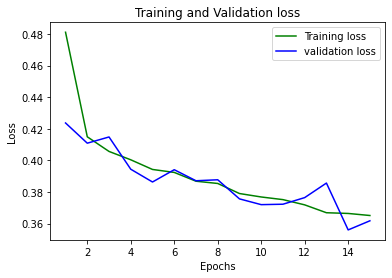

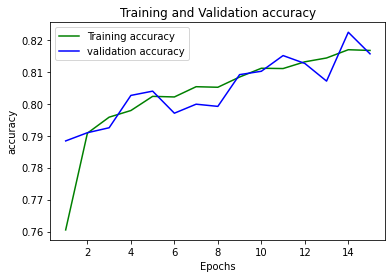

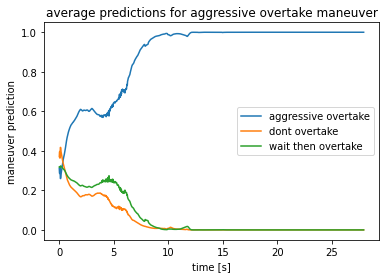

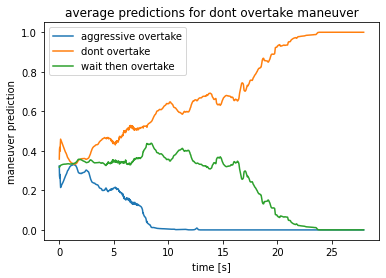

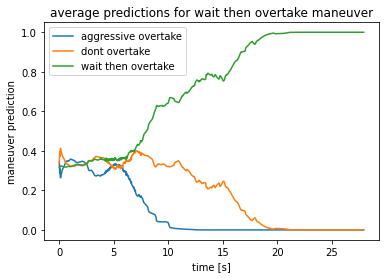

In [ ]:
import argparse
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

def main (args):  

  # Load data
  directory = "/content/drive/MyDrive/CS230_Project/ControlData/Trials/"
  X_train, Y_train, X_test, Y_test, X_1s_predict = data_initialize(directory)
  
  # Model traininig / testing
  model_parameters = {'task': args.task,
                      'model_type': args.model_type,
                      'h_dim': args.h_dim,
                      'n_layer': args.n_layer,
                      'batch_size': args.batch_size,
                      'epoch': args.epoch,
                      'metric_name': args.metric_name,
                      'learning_rate': args.learning_rate}
  
  if args.model_type in ['rnn','lstm','gru']:
    general_rnn = RNN_Classification(model_parameters)
    model = general_rnn.build_model(X_train.shape[1], X_train.shape[2])
    out = general_rnn.fit(model, X_train, Y_train, X_test, Y_test)
  
  # Evaluation
  loss_graph(out, args.epoch)
  acc_graph(out, args.epoch)
  misc_graph(model, X_1s_predict) 
    
##  
if __name__ == '__main__':
  args = args()
  # Call main function  
  main(args)